In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# fashion_mnist图像分类数据集
fashion_mnist = keras.datasets.fashion_mnist

(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

#得到的是np，训练集，验证集，测试集
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

4423680/4422102 [==============================] - 2s 0us/step
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [3]:
28*28  #如果非要对应多少特征，就是784个特征

784

In [4]:
type(x_train)

numpy.ndarray

In [5]:
y_train[0]

4

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  44 127 182 185 161 120  55
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  42 198 251 255 251 249 247 255 252
  214 100   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   0   0 233 252 237 239 234 237 235 237 237
  254 227   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   2   0   0  16 210 225 215 175 217 216 193 196 226
  221 209  50   0   0   2   0   0   0   0]
 [  0   0   0   0   2   0   0 199 229 232 230 245 204 219 253 245 207 194
  223 231 236 235   0   0   3   0   0   0]
 [  0   0   0   0   1   0 137 235 204 209 201 209 234 190 234 218 215 238
  239 204 189 224 154   0   0   0   0   0]
 [  0   0   0   0   0   0 194 201 200 209 202 193 205 194 183 218 231 197
  172 181 193 205 199   0   0   0   0   0]
 [  0   0   0   0   0   3 212 203 188 189 196 198 198 201 196 21

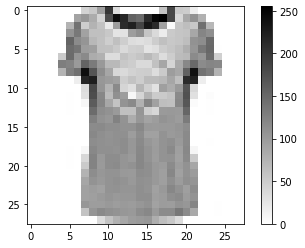

184
0


In [6]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.colorbar()  #旁边显示一个色阶条
    plt.show()


#依次看一下x_train[0]，x_train[1]，x_train[2]就可以理解下面的循环
print(x_train[0])
show_single_image(x_train[1])
print(x_train[1,0,18])
print(y_train[1])

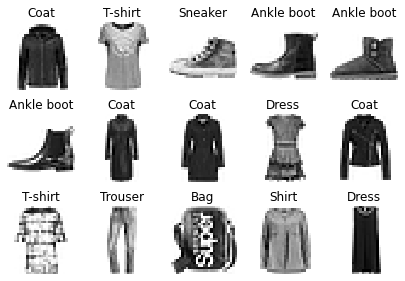

In [7]:
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)  #x和y的样本数一致
    assert n_rows * n_cols < len(x_data)  #确保打印的图片小于总样本数
    plt.figure(figsize = (n_cols * 1.4, n_rows * 1.6))  #宽1.4高1.6
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col 
            plt.subplot(n_rows, n_cols, index+1)#因为从1开始
            plt.imshow(x_data[index], cmap="binary",
                       interpolation = 'nearest')
            plt.axis('off')#去除坐标系
            plt.title(class_names[y_data[index]])
    plt.show()
#已知的图片类别
# lables在这个路径https://github.com/zalandoresearch/fashion-mnist
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
#只是打印了前15个样本
show_imgs(3, 5, x_train, y_train, class_names)


In [8]:
# tf.keras.models.Sequential(),可以看下官网
# 功能：Sequential将线性的层堆叠到一个tf.keras.Model

model = keras.models.Sequential()
#把28*28的图片展平为一个一维向量,通过下面打印可以看到两个想乘
model.add(keras.layers.Flatten(input_shape=[28, 28]))
print(model.output_shape)
#Dense是全连接层，添加全连接层，单元数是300，可以对比300和100的差异
# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
# y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))


# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(10, activation='softmax')
# ])



# reason for sparse: y->index. y->one_hot->[] 
#loss是损失函数 y如果只是一个数，那么使用sparse_categorical_crossentropy
#sparse_categorical_crossentropy计算稀疏分类crossentropy损失。
# 计算的分类值是 0,1,2,...9
# 如果是一个向量，那么使用categorical_crossentropy
# metrics模型在训练和测试期间要评估的指标列表
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

(None, 784)


In [9]:
model.layers  #总计有4层

In [10]:
#可以来算一下参数个数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [11]:
784*300+300

235500

In [12]:
300*100+100

30100

In [13]:
model.variables  #模型中自己训练的参数

[<tf.Variable 'dense/kernel:0' shape=(784, 300) dtype=float32, numpy=
 array([[-6.3208751e-02, -6.6430479e-02, -3.0130759e-02, ...,
         -1.7144915e-02, -4.1522533e-03, -6.3544959e-02],
        [ 2.1532178e-05,  5.8357567e-03,  3.9072998e-02, ...,
         -2.7468059e-02, -6.1895140e-02, -3.0321904e-02],
        [ 2.3856275e-02, -4.0434822e-02,  5.8078587e-02, ...,
          7.7221766e-03,  2.4025835e-02, -9.2149377e-03],
        ...,
        [ 3.8529620e-02,  3.7190944e-02, -5.9452020e-02, ...,
          4.1372977e-02,  6.1390504e-02,  8.8183060e-03],
        [ 5.0336480e-02, -5.8100943e-02, -2.1439195e-02, ...,
         -7.2454982e-02,  5.7899714e-02,  6.2152654e-02],
        [-2.8972264e-02,  2.3483515e-02,  4.0378541e-02, ...,
         -3.0480105e-02, -9.4789490e-03, -3.7473097e-02]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(300,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
#均匀分布
np.sqrt(6/300)

0.1414213562373095

In [15]:
model.variables[0].numpy().max()

0.0743963

In [16]:
np.sqrt(6/100)

0.2449489742783178

In [17]:
model.variables[2].numpy().max()

0.122450806

In [18]:
55000/20

2750.0

In [19]:
# [None, 784] * W + b -> [None, 300] W.shape [784, 300], b = [300]
#W是矩阵，b是一个偏置，是一个向量

In [20]:
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))  

Epoch 1/20
1719/1719 [==============================] - 8s 5ms/step - loss: 2.7634 - accuracy: 0.6972 - val_loss: 0.6691 - val_accuracy: 0.7658
Epoch 2/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5850 - accuracy: 0.7824 - val_loss: 0.5612 - val_accuracy: 0.8060
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5065 - accuracy: 0.8144 - val_loss: 0.5169 - val_accuracy: 0.8242
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4618 - accuracy: 0.8306 - val_loss: 0.4820 - val_accuracy: 0.8396
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4311 - accuracy: 0.8405 - val_loss: 0.4604 - val_accuracy: 0.8468
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4103 - accuracy: 0.8486 - val_loss: 0.4526 - val_accuracy: 0.8482
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3937 - accuracy: 0.8527 - val_loss: 0.4454 - val_accuracy:

In [21]:
type(history)

tensorflow.python.keras.callbacks.History

In [11]:
#十次历史的信息
history.history

{'loss': [2.0217154026031494,
  0.5904763340950012,
  0.519915759563446,
  0.47739025950431824,
  0.44535624980926514,
  0.42013484239578247,
  0.40235233306884766,
  0.3857731223106384,
  0.37339335680007935,
  0.36288654804229736,
  0.35216057300567627,
  0.3456742465496063,
  0.3361222743988037,
  0.33027195930480957,
  0.32318446040153503,
  0.3177378177642822,
  0.31097596883773804,
  0.30599266290664673,
  0.3006281852722168,
  0.29516538977622986],
 'accuracy': [0.7130545377731323,
  0.7853636145591736,
  0.809145450592041,
  0.8227272629737854,
  0.836509108543396,
  0.8455818295478821,
  0.8524545431137085,
  0.857909083366394,
  0.8622182011604309,
  0.8656363487243652,
  0.8703818321228027,
  0.8715636134147644,
  0.8750908970832825,
  0.8767091035842896,
  0.8809818029403687,
  0.8819817900657654,
  0.8842545747756958,
  0.8873090744018555,
  0.8893454670906067,
  0.8910363912582397],
 'val_loss': [0.6178706288337708,
  0.5341334342956543,
  0.49793902039527893,
  0.4786155

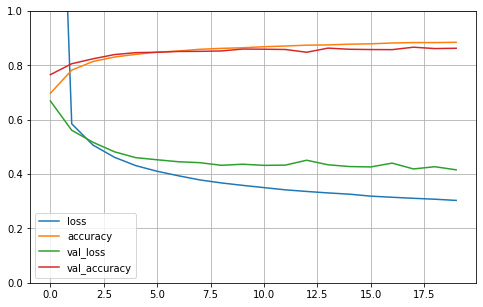

In [22]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [23]:
model.evaluate(x_test, y_test, verbose=0)

[0.4443906843662262, 0.845300018787384]

In [24]:
#计算标签和预测之间的crossentropy(交叉熵)损失
cce = keras.losses.SparseCategoricalCrossentropy()
loss = cce(
  [0, 1, 2],
  [[.9, .05, .05], [.05, .89, .06], [.05, .01, .94]])
print('Loss: ', loss.numpy())  

Loss:  0.09458992
